### INTRODUCTION

**About Dataset**

This dataset source from [kaggle](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment).

### IMPORT LIBRARY

In [82]:
# Basic modules
import os
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# nltk
import nltk
import re 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# Tensorflow keras
import tensorflow as tf
from transformers import  TFBertForSequenceClassification, BertTokenizer
from tensorflow.keras.models import load_model


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nurfiahidris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nurfiahidris/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### LOAD DATA

In [4]:
df = pd.read_csv('dataset/Tweets.csv')

In [5]:
# Get the shape of dataset (total column and total rows)
df.shape

(14640, 15)

In [6]:
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

The column name "airline_sentiment" is the label of this dataset and we will take the data from dataset with "neutral" and "negative" label only.

In [8]:
df_new = df.loc[df['airline_sentiment'].isin(["neutral","negative"])]
df_new['airline_sentiment'].unique()

array(['neutral', 'negative'], dtype=object)

In [9]:
print(f"The original dataset consist of {df.shape[0]} rows and the dataset that we will be use here is {df_new.shape[0]} rows which means the total of {df.shape[0]-df_new.shape[0]} rows will not be used for training.")

The original dataset consist of 14640 rows and the dataset that we will be use here is 12277 rows which means the total of 2363 rows will not be used for training.


In [10]:
# Display missing value rate on each column
missing = df_new.isnull().sum()/df_new.shape[0]*100
df_new.isnull().sum()


tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   3099
negativereason_confidence        2085
airline                             0
airline_sentiment_gold          12242
name                                0
negativereason_gold             12245
retweet_count                       0
text                                0
tweet_coord                     11433
tweet_created                       0
tweet_location                   4104
user_timezone                    4141
dtype: int64

In [11]:
# Get only the column of text and the label of data.
clean_data = df_new[['airline_sentiment','text']]
clean_data.head(2)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
2,neutral,@VirginAmerica I didn't today... Must mean I n...


<AxesSubplot:xlabel='airline_sentiment', ylabel='count'>

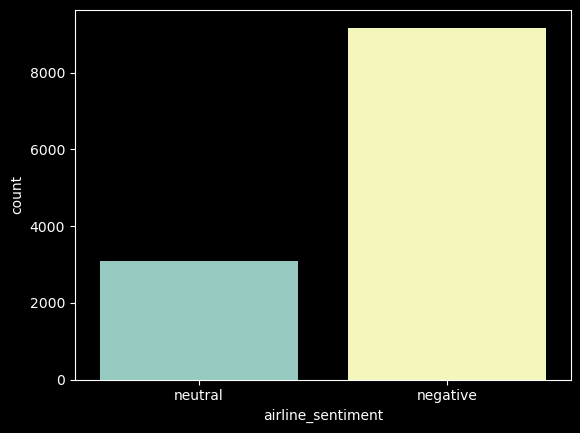

In [12]:
sns.countplot(x='airline_sentiment', data = clean_data)

The data we have is an imbalance data. The total data of negative sentiment is 50% higher than the neutral one.

In [ ]:
neutral_sentiment_df = clean_data[clean_data['airline_sentiment'] == 'neutral']
negative_sentiment_index = clean_data[clean_data['airline_sentiment'] == 'negative'].sample(neutral_sentiment_df.shape[0]).index
negative_sentiment_df = clean_data.loc[negative_sentiment_index]
balanced_dataset_df = neutral_sentiment_df.append(negative_sentiment_df, ignore_index=True)

### SOME EXPERIMENT

#### DATA PREPROCESSING

1. Encode label into numeric type
2. Replace all @user_name to the word 'users'
3. Replace all url link to the word 'url
4. Replace 3 or more consecutive letters by 2 letter
5. Tokenization
6. Removing stopwords using corpus stopwords from nltk

In [13]:
clean_data['airline_sentiment']= [1 if label == "neutral" else 0 for label in clean_data['airline_sentiment']]

/var/folders/z1/vlgwmylx7rs4_z4tpbjtft7r0000gn/T/ipykernel_1510/3698909039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['airline_sentiment']= [1 if label == "neutral" else 0 for label in clean_data['airline_sentiment']]


In [14]:
# Create function for processing each text
def processing_data(text):

    # Replace all @user_name to the word 'users'
    tagPattern = '@[^\s]+'
    sentence = re.sub(tagPattern, "user", text)
    
    # Replace all url link to the word 'url
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    sentence = re.sub(urlPattern, "url", sentence)

    # Replace 3 or more redundant letters by 2 letter
    sequencePattern   = r"(.)\1\1+"
    sequenceReplacer = r"\1\1"
    sentence = re.sub(sequencePattern, sequenceReplacer, sentence)
    
    # Tokenization
    tokens = nltk.word_tokenize(sentence)

    # Stopwords removal
    filtered_tokens = ' '.join([token for token in tokens if token.lower() not in stopwords])
    return filtered_tokens

In [15]:
clean_data['text'] = clean_data['text'].map(processing_data)
clean_data.head()

/var/folders/z1/vlgwmylx7rs4_z4tpbjtft7r0000gn/T/ipykernel_1510/2978784766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['text'] = clean_data['text'].map(processing_data)


,airline_sentiment,text
0,1,user user said .
2,1,user n't today .. Must mean need take another ...
3,0,user 's really aggressive blast obnoxious `` e...
4,0,user 's really big bad thing
5,0,user seriously would pay $ 30 flight seats n't...


##### Data Exploration

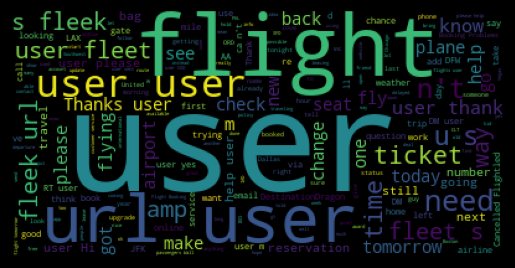

In [16]:
# Plotting data with neutral label using wordcloud
data_neutral = clean_data[clean_data['airline_sentiment'] == 1]
wordcloud = WordCloud().generate(' '.join(data_neutral['text']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

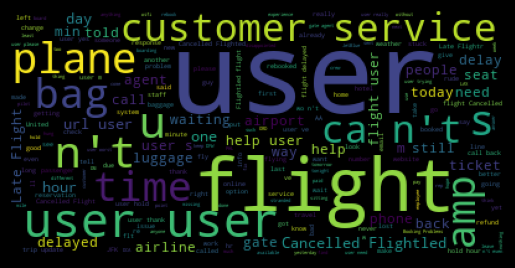

In [17]:
# Plotting data with negative label using wordcloud
data_negative = clean_data[clean_data['airline_sentiment'] == 0]
wordcloud = WordCloud().generate(' '.join(data_negative['text']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##### Handle Imbalance Data

#### MODEL TRAINING

##### Splitting Data

In [18]:
# This kind of splitting data used for training data into Logistic Regression model
x_train, x_test, y_train, y_test = train_test_split(clean_data['text'], clean_data['airline_sentiment'],
                                                    test_size = 0.2, random_state = 0)

In [19]:
# This kind of splitting data used for training data on deep learning architecture model
train,test = train_test_split(clean_data,train_size = 0.8,test_size=0.2, shuffle=False)

In [20]:
# Doing TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit_transform(x_train)


<9821x73948 sparse matrix of type '<class 'numpy.float64'>'
	with 193130 stored elements in Compressed Sparse Row format>

In [21]:
# Transform the training data into vectorizer
x_train = vectorizer.transform(x_train)
x_test  = vectorizer.transform(x_test)

##### Model Using Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7823, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
logistic_regression.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=7823)

In [23]:
y_pred_logistic_regression = logistic_regression.predict(x_test)
print(confusion_matrix(y_test, y_pred_logistic_regression))
print(classification_report(y_test, y_pred_logistic_regression))
print(accuracy_score(y_test, y_pred_logistic_regression))

[[1771   49]
 [ 396  240]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1820
           1       0.83      0.38      0.52       636

    accuracy                           0.82      2456
   macro avg       0.82      0.68      0.70      2456
weighted avg       0.82      0.82      0.79      2456

0.8188110749185668


##### Model Using Transfer Learning BERT Architecture

In [24]:
# Load the pre-trained BERT model
bert_model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-12 05:09:37.670525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-12 05:09:37.671626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


##### Data Conversion To BERT Format

In this following section of using transfer learning of BERT architecture, we will not use the data that has been preprocessing before using TfIdVectorizer but BertTokenizer, and in the other hand we will convert our raw data to be the format that are accepted and ready to use for training in the BERT architecture model.

In [116]:
max_length = 512 # max length for BERT can be more than this
batch_size = 6

def convert_to_feature(review):
  return tokenizer.encode_plus(review,
    add_special_tokens = True,
    max_length = max_length, 
    pad_to_max_length = True,
    return_attention_mask = True,
  )

In [117]:
def map_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [118]:
def encode(ds):
  # prepare list, so that we can build up final TensorFlow dataset from slices.
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
  for index, row in ds.iterrows():
    bert_input = convert_to_feature(row['text'])
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([row['airline_sentiment']])
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_to_dict)

In [119]:
# data encoding for training and testing dataset
train_encoded = encode(train).batch(batch_size)
test_encoded = encode(test).batch(batch_size)

In [109]:
number_of_epochs = 1
def model_compile(learning_rate,):
    # Here we will use Adam optimizer and the recommendation for Adam learning rate are (5e-5, 3e-5, 2e-5)
    learning_rate = learning_rate
    number_of_epochs = number_of_epochs

    # Initialize Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

    # Initialize the loss validation metric by using sparce categorical cross entropy and accuracy
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

    # Model compiling before fit to the BERT model
    bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [110]:
# using learning rate of 5e-5
model_compile(5e-5)

In [89]:
bert_history = bert_model.fit(train_encoded, epochs=number_of_epochs, validation_data=test_encoded)

2023-02-12 05:46:24.468470: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-02-12 05:46:35.071077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1637/1637 [==============================] - ETA: 0s - loss: 0.3830 - accuracy: 0.8301 WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


2023-02-12 10:49:15.479942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1637/1637 [==============================] - 18743s 11s/step - loss: 0.3830 - accuracy: 0.8301 - val_loss: 0.3058 - val_accuracy: 0.8652


In [96]:
bert_history.history

{'loss': [0.38303571939468384],
 'accuracy': [0.8300580382347107],
 'val_loss': [0.30575621128082275],
 'val_accuracy': [0.8652280569076538]}

In [ ]:
# save model 
bert_model.save("model")

# load model
bert_model = load_model('model')


#### HYPERPARAMETER TUNNING

In [120]:
# Using learning rate of 2e-5
model_compile(2e-5)

In [121]:
bert_history2 = bert_model.fit(train_encoded, epochs=number_of_epochs, validation_data=test_encoded)

2023-02-12 12:22:16.773739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1168/1637 [====================>.........] - ETA: 2:23:34 - loss: 0.4373 - accuracy: 0.8022

#### MODEL EVALUATION

#### MODEL INFERENCE

In this part, we will try to do some prediction using random sample new text of comment to see the performance of our model.

In [102]:
negative_random_text = "I was disappointed with their service that lost my baggage"
neutral_random_text = "It's been an honour to have the flight with this airline"

In [103]:
def predict_text(text):
    preprocess_input = tokenizer.encode(text, truncation=True, padding=True, return_tensors="tf")
    output = bert_model.predict(preprocess_input)[0]
    prediction = tf.nn.softmax(output, axis=1)
    labels = ['Negative','Neutral']
    label = tf.argmax(prediction, axis=1)
    label = label.numpy()
    print(f'The model predict the random text is : {labels[label[0]]} sentiment')

In [104]:
# Negative sentiment prediction
predict_text(negative_random_text)

The model predict the random text is : Negative sentiment


In [106]:
# Neutral sentiment prediction
predict_text(neutral_random_text)

The model predict the random text is : Neutral sentiment


#### CONCLUSION